# Insurance cost prediction using linear regression


In [2]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
!pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib pandas torch torchvision torchaudio

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [40]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [41]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [42]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [43]:
your_name = 'Afifah'

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [44]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [45]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
27,55,female,33.4305,2,no,northwest,12882.063862
752,64,male,38.6631,0,no,northwest,14921.062747
1258,55,male,38.4693,3,no,northwest,31566.759578
384,44,male,22.5777,2,no,northeast,8717.662432
406,33,female,24.7962,0,no,southeast,4394.352795


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [46]:
num_rows = len(dataframe)
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [47]:
num_cols = dataframe.shape[1]
print(num_cols)

7


**Q: What are the column titles of the input variables?**

In [48]:
input_cols = [i for i in dataframe.columns[:-1]]
input_cols

['age', 'sex', 'bmi', 'children', 'smoker', 'region']

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [49]:
categorical_cols = dataframe.select_dtypes(exclude = ['number'])
categorical_cols

,sex,smoker,region
27,female,no,northwest
752,male,no,northwest
1258,male,no,northwest
384,male,no,northeast
406,female,no,southeast
...,...,...,...
909,female,yes,southwest
861,female,no,southwest
463,male,no,northeast
1150,female,no,northeast


**Q: What are the column titles of output/target variable(s)?**

In [50]:
output_cols = dataframe.columns[-1]
output_cols

'charges'

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [51]:
# Write your answer here
charges = dataframe['charges']
charges.describe()

count     1271.000000
mean     13957.905484
std      12760.977804
min       1177.967595
25%       4954.806990
50%       9860.913300
75%      17682.701369
max      66958.949411
Name: charges, dtype: float64

(array([510., 377., 121.,  83.,  33.,  56.,  54.,  31.,   2.,   4.]),
 array([ 1177.967595  ,  7756.06577655, 14334.1639581 , 20912.26213965,
        27490.3603212 , 34068.45850275, 40646.5566843 , 47224.65486585,
        53802.7530474 , 60380.85122895, 66958.9494105 ]),
 <BarContainer object of 10 artists>)

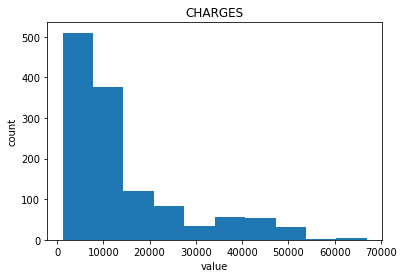

In [52]:
plt.xlabel('value')
plt.ylabel('count')
plt.title('CHARGES')
plt.hist(charges)


Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [53]:
!pip install jovian --upgrade -q

In [54]:
import jovian

In [55]:
jovian.commit(project='02-insurance-linear.ipynb')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Creating a new project "afifahluqman/02-insurance-linear.ipynb"
[jovian] Uploading notebook..
[jovian] Uploading additional files...
[jovian] Committed successfully! https://jovian.ai/afifahluqman/02-insurance-linear-26958


'https://jovian.ai/afifahluqman/02-insurance-linear-26958'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [56]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [57]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[55.    ,  0.    , 33.4305,  2.    ,  0.    ,  1.    ],
        [64.    ,  1.    , 38.6631,  0.    ,  0.    ,  1.    ],
        [55.    ,  1.    , 38.4693,  3.    ,  0.    ,  1.    ],
        ...,
        [56.    ,  1.    , 26.4537,  0.    ,  0.    ,  0.    ],
        [18.    ,  0.    , 30.9111,  0.    ,  0.    ,  0.    ],
        [43.    ,  1.    , 26.5506,  0.    ,  0.    ,  0.    ]]),
 array([12882.0638625, 14921.0627475, 31566.7595775, ..., 11723.6885325,
         2313.9227475,  7179.237135 ]))

In [58]:
jovian.commit(project='02-insurance-linear.ipynb')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Creating a new project "afifahluqman/02-insurance-linear.ipynb"
[jovian] Uploading notebook..
[jovian] Uploading additional files...
[jovian] Committed successfully! https://jovian.ai/afifahluqman/02-insurance-linear-108e5


'https://jovian.ai/afifahluqman/02-insurance-linear-108e5'

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [59]:
inputs = torch.Tensor(inputs_array)
targets = torch.Tensor(targets_array)

In [60]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [83]:
targets.shape, inputs.shape

(torch.Size([1271]), torch.Size([1271, 6]))

In [85]:
targets = targets.unsqueeze(1)

In [87]:
targets.shape, inputs.shape

(torch.Size([1271, 1]), torch.Size([1271, 6]))

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [88]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [89]:
val_percent = 0.12 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [90]:
batch_size = 70

In [91]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [92]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[59.0000,  1.0000, 30.2940,  2.0000,  0.0000,  2.0000],
        [45.0000,  1.0000, 23.3529,  0.0000,  1.0000,  0.0000],
        [32.0000,  1.0000, 32.1300,  1.0000,  0.0000,  3.0000],
        [25.0000,  0.0000, 34.6698,  1.0000,  0.0000,  2.0000],
        [57.0000,  1.0000, 34.6902,  0.0000,  0.0000,  1.0000],
        [30.0000,  1.0000, 24.6126,  1.0000,  0.0000,  1.0000],
        [51.0000,  0.0000, 41.4732,  0.0000,  0.0000,  0.0000],
        [31.0000,  1.0000, 39.1578,  2.0000,  0.0000,  2.0000],
        [42.0000,  0.0000, 30.0696,  2.0000,  0.0000,  2.0000],
        [41.0000,  0.0000, 32.8440,  1.0000,  0.0000,  3.0000],
        [49.0000,  0.0000, 23.0622,  1.0000,  0.0000,  1.0000],
        [53.0000,  0.0000, 38.8212,  3.0000,  0.0000,  2.0000],
        [51.0000,  1.0000, 32.9460,  1.0000,  0.0000,  0.0000],
        [58.0000,  0.0000, 32.4615,  2.0000,  0.0000,  0.0000],
        [18.0000,  1.0000, 30.6306,  1.0000,  0.0000,  2.0000],
        [64.0000,  0.0000, 40.11

Let's save our work by committing to Jovian.

In [93]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "afifahluqman/02-insurance-linear-regression" on https://jovian.ai
[jovian] Uploading notebook..
[jovian] Uploading additional files...
[jovian] Committed successfully! https://jovian.ai/afifahluqman/02-insurance-linear-regression


'https://jovian.ai/afifahluqman/02-insurance-linear-regression'

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [94]:
input_size = len(input_cols)
output_size = len(output_cols)

In [95]:
print(input_size), print(output_size)

6
7


(None, None)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [96]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                         # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                           # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.mse_loss(inputs, targets)                             # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [97]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [98]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1676,  0.2671, -0.2110, -0.2213, -0.1679, -0.2027],
         [-0.3319,  0.3394, -0.2813,  0.2211, -0.4021,  0.1295],
         [ 0.3256, -0.0065, -0.3907, -0.0562, -0.3768,  0.2760],
         [-0.2479,  0.1877, -0.3898, -0.0600,  0.2396,  0.2712],
         [-0.1765,  0.0367, -0.3887,  0.3682,  0.1655, -0.3159],
         [ 0.0448, -0.4022, -0.1897,  0.2905,  0.1193,  0.1497],
         [ 0.3458, -0.1965, -0.0008, -0.2224,  0.3532,  0.0884]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0893,  0.3736,  0.2179,  0.3589, -0.0336, -0.0999,  0.0824],
        requires_grad=True)]

One final commit before we train the model.

In [99]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "afifahluqman/02-insurance-linear-regression" on https://jovian.ai
[jovian] Uploading notebook..
[jovian] Uploading additional files...
[jovian] Committed successfully! https://jovian.ai/afifahluqman/02-insurance-linear-regression


'https://jovian.ai/afifahluqman/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [100]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [101]:
result = evaluate(model,val_loader) # Use the the evaluate function
print(result)

{'val_loss': 233543296.0}


<ipython-input-96-2425a3349f9e>:23: UserWarning: Using a target size (torch.Size([70, 1])) that is different to the input size (torch.Size([70, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(inputs, targets)                             # fill this
<ipython-input-96-2425a3349f9e>:23: UserWarning: Using a target size (torch.Size([12, 1])) that is different to the input size (torch.Size([12, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(inputs, targets)                             # fill this



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [104]:
epochs = 1000
lr = 1e-4
history1 = fit(epochs, lr, model, train_loader, val_loader)

<ipython-input-96-2425a3349f9e>:15: UserWarning: Using a target size (torch.Size([70, 1])) that is different to the input size (torch.Size([70, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(out, targets)                           # fill this
<ipython-input-96-2425a3349f9e>:15: UserWarning: Using a target size (torch.Size([69, 1])) that is different to the input size (torch.Size([69, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(out, targets)                           # fill this
<ipython-input-96-2425a3349f9e>:23: UserWarning: Using a target size (torch.Size([70, 1])) that is different to the input size (torch.Size([70, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(inputs, targets)                             # fill this
<ipython-input-96-2425

Epoch [20], val_loss: 233543296.0000
Epoch [40], val_loss: 233543296.0000
Epoch [60], val_loss: 233543296.0000
Epoch [80], val_loss: 233543296.0000
Epoch [100], val_loss: 233543296.0000
Epoch [120], val_loss: 233543296.0000
Epoch [140], val_loss: 233543296.0000
Epoch [160], val_loss: 233543296.0000
Epoch [180], val_loss: 233543296.0000
Epoch [200], val_loss: 233543296.0000
Epoch [220], val_loss: 233543296.0000
Epoch [240], val_loss: 233543296.0000
Epoch [260], val_loss: 233543296.0000
Epoch [280], val_loss: 233543296.0000
Epoch [300], val_loss: 233543296.0000
Epoch [320], val_loss: 233543296.0000
Epoch [340], val_loss: 233543296.0000
Epoch [360], val_loss: 233543296.0000
Epoch [380], val_loss: 233543296.0000
Epoch [400], val_loss: 233543296.0000
Epoch [420], val_loss: 233543296.0000
Epoch [440], val_loss: 233543296.0000
Epoch [460], val_loss: 233543296.0000
Epoch [480], val_loss: 233543296.0000
Epoch [500], val_loss: 233543296.0000
Epoch [520], val_loss: 233543296.0000
Epoch [540], val

In [107]:
epochs = 1000
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

<ipython-input-96-2425a3349f9e>:15: UserWarning: Using a target size (torch.Size([70, 1])) that is different to the input size (torch.Size([70, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(out, targets)                           # fill this
<ipython-input-96-2425a3349f9e>:15: UserWarning: Using a target size (torch.Size([69, 1])) that is different to the input size (torch.Size([69, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(out, targets)                           # fill this
<ipython-input-96-2425a3349f9e>:23: UserWarning: Using a target size (torch.Size([70, 1])) that is different to the input size (torch.Size([70, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(inputs, targets)                             # fill this
<ipython-input-96-2425

Epoch [20], val_loss: 233543296.0000
Epoch [40], val_loss: 233543296.0000
Epoch [60], val_loss: 233543296.0000
Epoch [80], val_loss: 233543296.0000
Epoch [100], val_loss: 233543296.0000
Epoch [120], val_loss: 233543296.0000
Epoch [140], val_loss: 233543296.0000
Epoch [160], val_loss: 233543296.0000
Epoch [180], val_loss: 233543296.0000
Epoch [200], val_loss: 233543296.0000
Epoch [220], val_loss: 233543296.0000
Epoch [240], val_loss: 233543296.0000
Epoch [260], val_loss: 233543296.0000
Epoch [280], val_loss: 233543296.0000
Epoch [300], val_loss: 233543296.0000
Epoch [320], val_loss: 233543296.0000
Epoch [340], val_loss: 233543296.0000
Epoch [360], val_loss: 233543296.0000
Epoch [380], val_loss: 233543296.0000
Epoch [400], val_loss: 233543296.0000
Epoch [420], val_loss: 233543296.0000
Epoch [440], val_loss: 233543296.0000
Epoch [460], val_loss: 233543296.0000
Epoch [480], val_loss: 233543296.0000
Epoch [500], val_loss: 233543296.0000
Epoch [520], val_loss: 233543296.0000
Epoch [540], val

In [106]:
epochs = 1000
lr = 1e-2
history3 = fit(epochs, lr, model, train_loader, val_loader)

<ipython-input-96-2425a3349f9e>:15: UserWarning: Using a target size (torch.Size([70, 1])) that is different to the input size (torch.Size([70, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(out, targets)                           # fill this
<ipython-input-96-2425a3349f9e>:15: UserWarning: Using a target size (torch.Size([69, 1])) that is different to the input size (torch.Size([69, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(out, targets)                           # fill this
<ipython-input-96-2425a3349f9e>:23: UserWarning: Using a target size (torch.Size([70, 1])) that is different to the input size (torch.Size([70, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(inputs, targets)                             # fill this
<ipython-input-96-2425

Epoch [20], val_loss: 233543296.0000
Epoch [40], val_loss: 233543296.0000
Epoch [60], val_loss: 233543296.0000
Epoch [80], val_loss: 233543296.0000
Epoch [100], val_loss: 233543296.0000
Epoch [120], val_loss: 233543296.0000
Epoch [140], val_loss: 233543296.0000
Epoch [160], val_loss: 233543296.0000
Epoch [180], val_loss: 233543296.0000
Epoch [200], val_loss: 233543296.0000
Epoch [220], val_loss: 233543296.0000
Epoch [240], val_loss: 233543296.0000
Epoch [260], val_loss: 233543296.0000
Epoch [280], val_loss: 233543296.0000
Epoch [300], val_loss: 233543296.0000
Epoch [320], val_loss: 233543296.0000
Epoch [340], val_loss: 233543296.0000
Epoch [360], val_loss: 233543296.0000
Epoch [380], val_loss: 233543296.0000
Epoch [400], val_loss: 233543296.0000
Epoch [420], val_loss: 233543296.0000
Epoch [440], val_loss: 233543296.0000
Epoch [460], val_loss: 233543296.0000
Epoch [480], val_loss: 233543296.0000
Epoch [500], val_loss: 233543296.0000
Epoch [520], val_loss: 233543296.0000
Epoch [540], val

In [108]:
epochs = 1000
lr = 6e-2
history4 = fit(epochs, lr, model, train_loader, val_loader)

<ipython-input-96-2425a3349f9e>:15: UserWarning: Using a target size (torch.Size([70, 1])) that is different to the input size (torch.Size([70, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(out, targets)                           # fill this
<ipython-input-96-2425a3349f9e>:15: UserWarning: Using a target size (torch.Size([69, 1])) that is different to the input size (torch.Size([69, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(out, targets)                           # fill this
<ipython-input-96-2425a3349f9e>:23: UserWarning: Using a target size (torch.Size([70, 1])) that is different to the input size (torch.Size([70, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(inputs, targets)                             # fill this
<ipython-input-96-2425

Epoch [20], val_loss: 233543296.0000
Epoch [40], val_loss: 233543296.0000
Epoch [60], val_loss: 233543296.0000
Epoch [80], val_loss: 233543296.0000
Epoch [100], val_loss: 233543296.0000
Epoch [120], val_loss: 233543296.0000
Epoch [140], val_loss: 233543296.0000
Epoch [160], val_loss: 233543296.0000
Epoch [180], val_loss: 233543296.0000
Epoch [200], val_loss: 233543296.0000
Epoch [220], val_loss: 233543296.0000
Epoch [240], val_loss: 233543296.0000
Epoch [260], val_loss: 233543296.0000
Epoch [280], val_loss: 233543296.0000
Epoch [300], val_loss: 233543296.0000
Epoch [320], val_loss: 233543296.0000
Epoch [340], val_loss: 233543296.0000
Epoch [360], val_loss: 233543296.0000
Epoch [380], val_loss: 233543296.0000
Epoch [400], val_loss: 233543296.0000
Epoch [420], val_loss: 233543296.0000
Epoch [440], val_loss: 233543296.0000
Epoch [460], val_loss: 233543296.0000
Epoch [480], val_loss: 233543296.0000
Epoch [500], val_loss: 233543296.0000
Epoch [520], val_loss: 233543296.0000
Epoch [540], val

In [109]:
epochs = 1000
lr = 5e-4
history5 = fit(epochs, lr, model, train_loader, val_loader)

<ipython-input-96-2425a3349f9e>:15: UserWarning: Using a target size (torch.Size([70, 1])) that is different to the input size (torch.Size([70, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(out, targets)                           # fill this
<ipython-input-96-2425a3349f9e>:15: UserWarning: Using a target size (torch.Size([69, 1])) that is different to the input size (torch.Size([69, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(out, targets)                           # fill this
<ipython-input-96-2425a3349f9e>:23: UserWarning: Using a target size (torch.Size([70, 1])) that is different to the input size (torch.Size([70, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(inputs, targets)                             # fill this
<ipython-input-96-2425

Epoch [20], val_loss: 233543296.0000
Epoch [40], val_loss: 233543296.0000
Epoch [60], val_loss: 233543296.0000
Epoch [80], val_loss: 233543296.0000
Epoch [100], val_loss: 233543296.0000
Epoch [120], val_loss: 233543296.0000
Epoch [140], val_loss: 233543296.0000
Epoch [160], val_loss: 233543296.0000
Epoch [180], val_loss: 233543296.0000
Epoch [200], val_loss: 233543296.0000
Epoch [220], val_loss: 233543296.0000
Epoch [240], val_loss: 233543296.0000
Epoch [260], val_loss: 233543296.0000
Epoch [280], val_loss: 233543296.0000
Epoch [300], val_loss: 233543296.0000
Epoch [320], val_loss: 233543296.0000
Epoch [340], val_loss: 233543296.0000
Epoch [360], val_loss: 233543296.0000
Epoch [380], val_loss: 233543296.0000
Epoch [400], val_loss: 233543296.0000
Epoch [420], val_loss: 233543296.0000
Epoch [440], val_loss: 233543296.0000
Epoch [460], val_loss: 233543296.0000
Epoch [480], val_loss: 233543296.0000
Epoch [500], val_loss: 233543296.0000
Epoch [520], val_loss: 233543296.0000
Epoch [540], val

**Q: What is the final validation loss of your model?**

In [110]:
val_loss = 233543296.0000

Let's log the final validation loss to Jovian and commit the notebook

In [111]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [112]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "afifahluqman/02-insurance-linear-regression" on https://jovian.ai
[jovian] Uploading notebook..
[jovian] Uploading additional files...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/afifahluqman/02-insurance-linear-regression


'https://jovian.ai/afifahluqman/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [114]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)         # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [115]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([32.0000,  1.0000, 28.6824,  4.0000,  1.0000,  1.0000])
Target: tensor([22546.1035])
Prediction: tensor([6385.4844, 6386.8652, 6385.2344, 6385.8418, 6387.9180, 6386.9062,
        6385.1528])


In [116]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([27.0000,  1.0000, 26.5506,  0.0000,  0.0000,  0.0000])
Target: tensor([3224.3491])
Prediction: tensor([5066.2075, 5065.9639, 5065.0776, 5065.2256, 5066.1123, 5065.0825,
        5065.1313])


In [117]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([18.0000,  1.0000, 26.7036,  2.0000,  0.0000,  2.0000])
Target: tensor([2419.2024])
Prediction: tensor([2667.0959, 2668.3887, 2667.2913, 2667.4712, 2667.8635, 2667.5586,
        2666.5293])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039

In [118]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "afifahluqman/02-insurance-linear-regression" on https://jovian.ai
[jovian] Uploading notebook..
[jovian] Uploading additional files...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/afifahluqman/02-insurance-linear-regression


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "afifahluqman/02-insurance-linear-regression" on https://jovian.ai
[jovian] Uploading notebook..
[jovian] Uploading additional files...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/afifahluqman/02-insurance-linear-regression


'https://jovian.ai/afifahluqman/02-insurance-linear-regression'